In [1]:
from tensorflow_model_optimization.sparsity import keras as sparsity
from sklearn.experimental import enable_iterative_imputer
from tensorflow.keras import datasets, layers, models
from sklearn.model_selection import train_test_split
from sklearn.impute import IterativeImputer
from sklearn.model_selection import KFold 
from IPython.display import clear_output
from keras.models import model_from_json
from scipy.interpolate import interp1d
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tensorflow import keras
from scipy import stats 
import tensorflow as tf
from tqdm import tqdm
import pandas as pd
import numpy as np
import math
import csv

D:\Software\Anaconda\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\Software\Anaconda\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\Software\Anaconda\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\Software\Anaconda\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:544: FutureWa

In [2]:
def replace_nan(x):
    if x==" ":
        return np.nan
    else :
        return float(x)

def norm(x, train_mean, train_std):
    if train_mean == 0 or train_std == 0:
        return x
    else:
        return (x - train_mean) / train_std

In [3]:
train = pd.read_csv("Train.csv")
test = pd.read_csv("Test.csv")
features = ["temp","precip","rel_humidity","wind_dir","wind_spd","atmos_press"]
for feature in features : 
    train[feature] = train[feature].apply(lambda x: [ replace_nan(X) for X in x.replace("nan"," ").split(",")])
    test[feature] = test[feature].apply(lambda x: [ replace_nan(X)  for X in x.replace("nan"," ").split(",")])

patterns =  len(train['temp'])
entries =  len(train['temp'][0])
num_features = len(features)
labels = np.array(train['target'])
count = 0
inputs = [0, 0, 0, 0, 0, 0]
for F in features:
    with open(F + '.txt', 'r') as f:
        l = ([[float(num) for num in line.split(' ')] for line in f])
    l = np.array(l)
    inputs[count] = l
    count += 1
    
# Locations to numbers
for i in range(patterns):
    if train['location'][i] == 'A':
        train['location'][i] = 1
    elif train['location'][i] == 'B':
        train['location'][i] = 2
    elif train['location'][i] == 'C':
        train['location'][i] = 3
    elif train['location'][i] == 'D':
        train['location'][i] = 4
    elif train['location'][i] == 'E':
        train['location'][i] = 5       
       
temperature, precipitation, humidity, wind_d, wind_s, pressure = inputs[0], inputs[1], inputs[2], inputs[3], inputs[4], inputs[5]

image = np.zeros((patterns, num_features + 1, entries, 1))
for i in range(patterns):
    image[i,0,:,0], image[i,1,:,0],image[i,2,:,0],image[i,3,:,0],image[i,4,:,0], image[i,5,:,0], image[i,6,:,0] = temperature[i], precipitation[i], humidity[i], wind_d[i], wind_s[i], pressure[i], np.ones(121)*(train.location[i])   
clear_output()

image_train, image_test, labels_train, labels_test = train_test_split(image, labels, test_size = 0.3, random_state = 777)

location = image_train[:,6,0,0]
location_test = image_test[:,6,0,0]

# CNN model

In [4]:
def CNN(x, y, epochs, folds, batchsize, sim):
        "----------------------------------------------------------------------"
        "This function returns a trained and tested model"
        "model based on data x and labels y over epochs."
        
        "The input data X must be of a matrix or tensor size only"
        "With shape = [patterns, features, entries, depth], depth can be null"
        "and is assumed 1"
        "----------------------------------------------------------------------"
        stop = EarlyStopping(monitor='val_loss', patience = 20, mode='min', verbose=0)
        patterns, num_features, num_entries, depth = x.shape
        kf = KFold(n_splits = folds, shuffle = True, random_state = 777)
        
        training_loss_fold = np.zeros((folds, epochs))
        testing_loss_fold = np.zeros((folds, epochs))
        
        fold = -1
        for train_index, test_index in kf.split(x):
            clear_output()
            fold += 1
            print("Simulation {}\nFold {}".format(sim,fold))
            X_train, X_test = x[train_index], x[test_index]
            y_train, y_test = y[train_index], y[test_index]
            # This standardizes the data.
            for i in range(num_features):
                m = np.mean(X_train[:,i,:])
                s = np.std(X_train[:,i,:])
                X_train[:,i,:] = norm(X_train[:,i,:], m, s)
                X_test[:,i,:] = norm(X_test[:,i,:], m, s)

            model = models.Sequential()
            model.add(layers.Conv2D(32, (1, 4), strides=(1, 1), padding='same', activation='relu', 
                                    input_shape = (num_features, num_entries, 1)))
            model.add(layers.Conv2D(32, (1, 4), strides=(1, 1), padding='valid', activation='relu'))
            model.add(layers.MaxPooling2D((3, 3)))
            model.add(layers.Dropout(0.2))
            model.add(layers.BatchNormalization())
            
            model.add(layers.Conv2D(64, (1, 4), strides=(1, 1), padding='valid', activation='relu'))
            model.add(layers.Conv2D(64, (1, 4), strides=(1, 1), padding='valid', activation='relu'))
            model.add(layers.MaxPooling2D((2, 2)))
            model.add(layers.Dropout(0.2))
            model.add(layers.BatchNormalization())
            
            model.add(layers.Conv2D(128, (1, 4), strides=(1, 1), padding='valid', activation='relu'))
            model.add(layers.Conv2D(128, (1, 4), strides=(1, 1), padding='valid', activation='relu'))
            model.add(layers.Flatten())
            model.add(layers.Dense(256, activation='relu'))
            model.add(layers.Dense(128, activation='relu'))
            model.add(layers.Dense(1))

            model.compile(loss='mse',
                        optimizer= 'adam' ,
                        metrics=['mae', 'mse'])

            history = model.fit(X_train, y_train, epochs = epochs, batch_size = batchsize, 
                            validation_data = (X_test, y_test),callbacks = [stop])
            
            loss_train = np.sqrt(history.history['loss'])
            loss_test = np.sqrt(history.history['val_loss'])
            
            #Determining Best Model
            lowest_test_loss = np.min(loss_test)
            
            if fold == 0:
                model_best = model
                lowest_validation = lowest_test_loss
            elif fold > 0:
                if lowest_test_loss < lowest_validation:
                    model_best = model
                    lowest_validation = lowest_test_loss
    
            training_loss_fold[fold] = loss_train
            testing_loss_fold[fold] = loss_test
            
        return model_best, training_loss_fold, testing_loss_fold, lowest_validation

# Training model for A

Final Training Mean RMSE: 15.682231614182282
Final Training STD RMSE: 0.07598533310753286
Final Validation Mean RMSE: 32.03376591541302
Final Validation STD RMSE: 0.12140274725705069
The Final Mean RMSE 40.24715531529857
The Final STD RMSE 0.4975376505689262
Overfit Mean 24.564923701116292
Overfit STD 0.5735229836764599
Saved model to disk


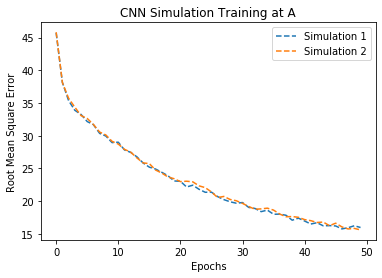

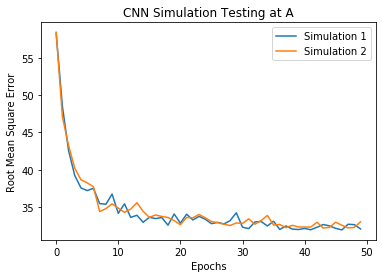

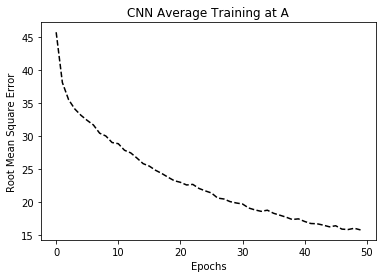

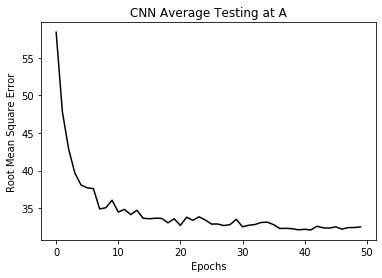

In [5]:
X_A = image_train[location == 1]
y_A = labels_train[location == 1]

k = 5
n_simulations = 5
epochs = 200
batchsize = 64
sim_train_A = np.zeros((n_simulations, epochs))
sim_test_A = np.zeros((n_simulations, epochs))
simulation_list_A = []

for sim in range(n_simulations):
    model_sim_best, Ltrain, Ltest, lowest_val = CNN(X_A, y_A, epochs, k, batchsize, sim)
    
    # Testing model
    data = image_test[location_test == 1]
    data_labels = labels_test[location_test == 1]
    m_label = np.mean(data)
    s_label = np.std(data)
    X_model = norm(data, m_label, s_label)
    R = model_sim_best.evaluate(X_model, data_labels, verbose = 0)
    simulation_list_A.append(R[0])
    
    if sim == 0:
        model_A_best = model_sim_best
        val_marker = lowest_val
    else:
        if lowest_val < val_marker:
            model_A_best = model_sim_best
            val_marker = lowest_val
    
    sim_train_A[sim] = np.mean(Ltrain, axis = 0)
    sim_test_A[sim] = np.mean(Ltest, axis = 0)
    
    plt.figure(1)
    plt.plot(range(epochs), sim_train_A[sim], '--', label = 'Simulation {}'.format(sim+1))
    plt.figure(2)
    plt.plot(range(epochs), sim_test_A[sim], label = 'Simulation {}'.format(sim+1))

plt.figure(3)    
plt.plot(range(epochs), np.mean(sim_train_A, axis = 0), 'k--')
plt.figure(4)    
plt.plot(range(epochs), np.mean(sim_test_A, axis = 0), 'k')

clear_output()

titles = ['CNN Simulation Training at A', 'CNN Simulation Testing at A','CNN Average Training at A', 'CNN Average Testing at A']
for i in range(4):
    plt.figure(i+1)
    plt.title(titles[i])
    plt.xlabel('Epochs')
    plt.ylabel('Root Mean Square Error')
    if i == 0 or i == 1:     
        plt.legend()   
        
overfit = np.sqrt(simulation_list_A) - np.min(sim_train_A, axis = 1)
train_min_mean = np.mean(np.min(sim_train_A, axis = 1))
train_min_std = np.std(np.min(sim_train_A, axis = 1))
test_min_mean = np.mean(np.min(sim_test_A, axis = 1))
test_min_std = np.std(np.min(sim_test_A, axis = 1))
print('Final Training Mean RMSE:',train_min_mean)
print('Final Training STD RMSE:',train_min_std)
print('Final Validation Mean RMSE:',test_min_mean)
print('Final Validation STD RMSE:',test_min_std)
print('The Final Mean RMSE', np.mean(np.sqrt(simulation_list_A)))
print('The Final STD RMSE', np.std(np.sqrt(simulation_list_A)))
print('Overfit Mean', np.mean(overfit))
print('Overfit STD', np.std(overfit))
#-----------------Saving model------------------
# serialize model to JSON
model_json = model_A_best.to_json()
with open("model_A_best.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model_A_best.save_weights("model_A_best.h5")
print("Saved model to disk")

# Training model for B

Final Training Mean RMSE: 9.238467722342943
Final Training STD RMSE: 0.6412274868676846
Final Validation Mean RMSE: 18.66096862085518
Final Validation STD RMSE: 0.12131298503662258
The Final Mean RMSE 34.2863173131779
The Final STD RMSE 2.4846246498934583
Overfit Mean 25.047849590834964
Overfit STD 1.8433971630257737
Saved model to disk


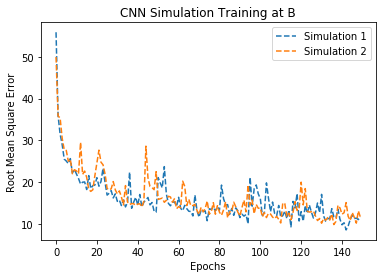

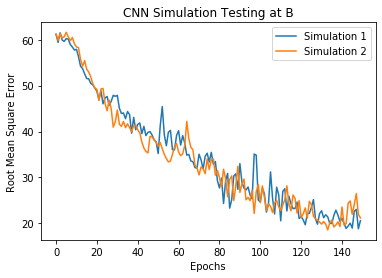

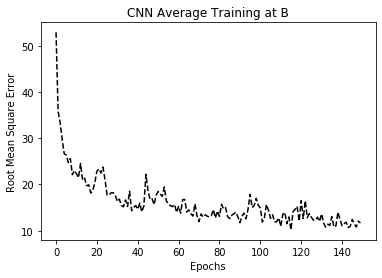

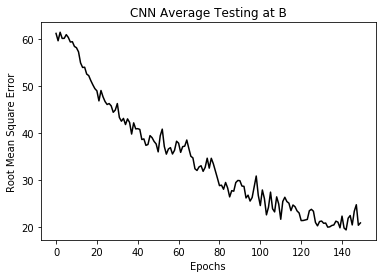

In [7]:
X_B = image_train[location == 2]
y_B = labels_train[location == 2]

k = 5
n_simulations = 5
epochs = 200
batchsize = 64
sim_train_B = np.zeros((n_simulations, epochs))
sim_test_B = np.zeros((n_simulations, epochs))
simulation_list_B = []

for sim in range(n_simulations):
    model_sim_best, Ltrain, Ltest, lowest_val = CNN(X_B, y_B, epochs, k, batchsize, sim)
    
    # Testing model
    data = image_test[location_test == 2]
    data_labels = labels_test[location_test == 2]
    m_label = np.mean(data)
    s_label = np.std(data)
    X_model = norm(data, m_label, s_label)
    R = model_sim_best.evaluate(X_model, data_labels, verbose = 0)
    simulation_list_B.append(R[0])
    
    if sim == 0:
        model_B_best = model_sim_best
        val_marker = lowest_val
    else:
        if lowest_val < val_marker:
            model_B_best = model_sim_best
            val_marker = lowest_val
    
    sim_train_B[sim] = np.mean(Ltrain, axis = 0)
    sim_test_B[sim] = np.mean(Ltest, axis = 0)
    
    plt.figure(1)
    plt.plot(range(epochs), sim_train_B[sim], '--', label = 'Simulation {}'.format(sim+1))
    plt.figure(2)
    plt.plot(range(epochs), sim_test_B[sim], label = 'Simulation {}'.format(sim+1))

plt.figure(3)    
plt.plot(range(epochs), np.mean(sim_train_B, axis = 0), 'k--')
plt.figure(4)    
plt.plot(range(epochs), np.mean(sim_test_B, axis = 0), 'k')

clear_output()

titles = ['CNN Simulation Training at B', 'CNN Simulation Testing at B','CNN Average Training at B', 'CNN Average Testing at B']
for i in range(4):
    plt.figure(i+1)
    plt.title(titles[i])
    plt.xlabel('Epochs')
    plt.ylabel('Root Mean Square Error')
    if i == 0 or i == 1:     
        plt.legend()   
        
overfit = np.sqrt(simulation_list_B) - np.min(sim_train_B, axis = 1)
train_min_mean = np.mean(np.min(sim_train_B, axis = 1))
train_min_std = np.std(np.min(sim_train_B, axis = 1))
test_min_mean = np.mean(np.min(sim_test_B, axis = 1))
test_min_std = np.std(np.min(sim_test_B, axis = 1))
print('Final Training Mean RMSE:',train_min_mean)
print('Final Training STD RMSE:',train_min_std)
print('Final Validation Mean RMSE:',test_min_mean)
print('Final Validation STD RMSE:',test_min_std)
print('The Final Mean RMSE', np.mean(np.sqrt(simulation_list_B)))
print('The Final STD RMSE', np.std(np.sqrt(simulation_list_B)))
print('Overfit Mean', np.mean(overfit))
print('Overfit STD', np.std(overfit))
#-----------------Saving model------------------
# serialize model to JSON
model_json = model_B_best.to_json()
with open("model_B_best.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model_B_best.save_weights("model_B_best.h5")
print("Saved model to disk")

# Training model for C

Final Training Mean RMSE: 7.9840804989162635
Final Training STD RMSE: 0.1406895624673261
Final Validation Mean RMSE: 44.356341792655556
Final Validation STD RMSE: 0.3250779634508909
The Final Mean RMSE 75.30824856895816
The Final STD RMSE 1.8488336207621074
Overfit Mean 67.3241680700419
Overfit STD 1.7081440582947849
Saved model to disk


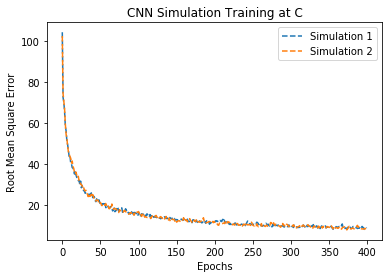

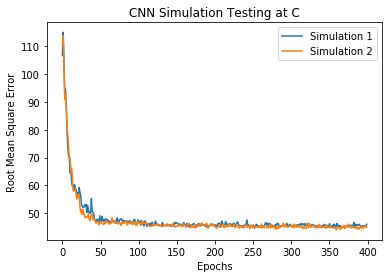

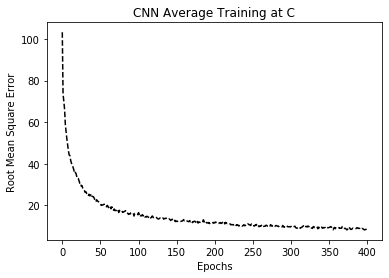

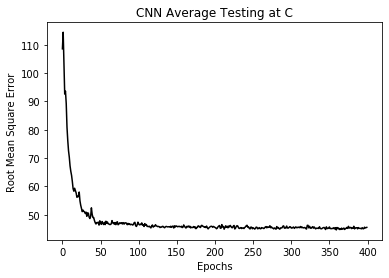

In [5]:
X_C = image_train[location == 3]
y_C = labels_train[location == 3]

k = 5
n_simulations = 5
epochs = 200
batchsize = 64
sim_train_C = np.zeros((n_simulations, epochs))
sim_test_C = np.zeros((n_simulations, epochs))
simulation_list_C = []

for sim in range(n_simulations):
    model_sim_best, Ltrain, Ltest, lowest_val = CNN(X_C, y_C, epochs, k, batchsize, sim)
    
    # Testing model
    data = image_test[location_test == 3]
    data_labels = labels_test[location_test == 3]
    m_label = np.mean(data)
    s_label = np.std(data)
    X_model = norm(data, m_label, s_label)
    R = model_sim_best.evaluate(X_model, data_labels, verbose = 0)
    simulation_list_C.append(R[0])
    
    if sim == 0:
        model_C_best = model_sim_best
        val_marker = lowest_val
    else:
        if lowest_val < val_marker:
            model_C_best = model_sim_best
            val_marker = lowest_val
    
    sim_train_C[sim] = np.mean(Ltrain, axis = 0)
    sim_test_C[sim] = np.mean(Ltest, axis = 0)
    
    plt.figure(1)
    plt.plot(range(epochs), sim_train_C[sim], '--', label = 'Simulation {}'.format(sim+1))
    plt.figure(2)
    plt.plot(range(epochs), sim_test_C[sim], label = 'Simulation {}'.format(sim+1))

plt.figure(3)    
plt.plot(range(epochs), np.mean(sim_train_C, axis = 0), 'k--')
plt.figure(4)    
plt.plot(range(epochs), np.mean(sim_test_C, axis = 0), 'k')

clear_output()

titles = ['CNN Simulation Training at C', 'CNN Simulation Testing at C','CNN Average Training at C', 'CNN Average Testing at C']
for i in range(4):
    plt.figure(i+1)
    plt.title(titles[i])
    plt.xlabel('Epochs')
    plt.ylabel('Root Mean Square Error')
    if i == 0 or i == 1:     
        plt.legend()   
        
overfit = np.sqrt(simulation_list_C) - np.min(sim_train_C, axis = 1)
train_min_mean = np.mean(np.min(sim_train_C, axis = 1))
train_min_std = np.std(np.min(sim_train_C, axis = 1))
test_min_mean = np.mean(np.min(sim_test_C, axis = 1))
test_min_std = np.std(np.min(sim_test_C, axis = 1))
print('Final Training Mean RMSE:',train_min_mean)
print('Final Training STD RMSE:',train_min_std)
print('Final Validation Mean RMSE:',test_min_mean)
print('Final Validation STD RMSE:',test_min_std)
print('The Final Mean RMSE', np.mean(np.sqrt(simulation_list_C)))
print('The Final STD RMSE', np.std(np.sqrt(simulation_list_C)))
print('Overfit Mean', np.mean(overfit))
print('Overfit STD', np.std(overfit))
#-----------------Saving model------------------
# serialize model to JSON
model_json = model_C_best.to_json()
with open("model_C_best.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model_C_best.save_weights("model_C_best.h5")
print("Saved model to disk")

# Training Model for D

Final Training Mean RMSE: 10.091805376941098
Final Training STD RMSE: 0.08467675982945089
Final Validation Mean RMSE: 20.17337207935008
Final Validation STD RMSE: 0.17862920567168847
The Final Mean RMSE 35.188724760131805
The Final STD RMSE 0.7580861940187376
Overfit Mean 25.09691938319071
Overfit STD 0.6734094341892867
Saved model to disk


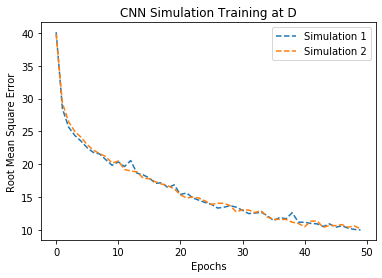

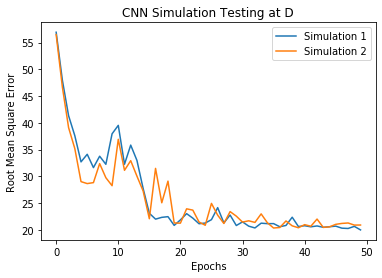

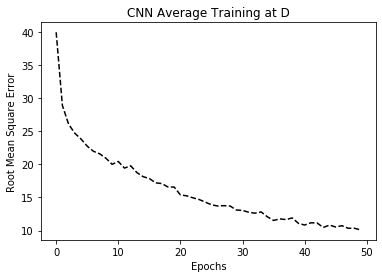

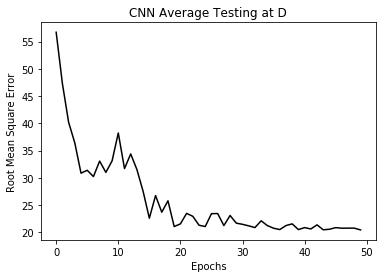

In [8]:
X_D = image_train[location == 4]
y_D = labels_train[location == 4]

k = 5
n_simulations = 5
epochs = 200
batchsize = 64
sim_train_D = np.zeros((n_simulations, epochs))
sim_test_D = np.zeros((n_simulations, epochs))
simulation_list_D = []

for sim in range(n_simulations):
    model_sim_best, Ltrain, Ltest, lowest_val = CNN(X_D, y_D, epochs, k, batchsize, sim)
    
    # Testing model
    data = image_test[location_test == 4]
    data_labels = labels_test[location_test == 4]
    m_label = np.mean(data)
    s_label = np.std(data)
    X_model = norm(data, m_label, s_label)
    R = model_sim_best.evaluate(X_model, data_labels, verbose = 0)
    simulation_list_D.append(R[0])
    
    if sim == 0:
        model_D_best = model_sim_best
        val_marker = lowest_val
    else:
        if lowest_val < val_marker:
            model_D_best = model_sim_best
            val_marker = lowest_val
    
    sim_train_D[sim] = np.mean(Ltrain, axis = 0)
    sim_test_D[sim] = np.mean(Ltest, axis = 0)
    
    plt.figure(1)
    plt.plot(range(epochs), sim_train_D[sim], '--', label = 'Simulation {}'.format(sim+1))
    plt.figure(2)
    plt.plot(range(epochs), sim_test_D[sim], label = 'Simulation {}'.format(sim+1))

plt.figure(3)    
plt.plot(range(epochs), np.mean(sim_train_D, axis = 0), 'k--')
plt.figure(4)    
plt.plot(range(epochs), np.mean(sim_test_D, axis = 0), 'k')

clear_output()

titles = ['CNN Simulation Training at D', 'CNN Simulation Testing at D','CNN Average Training at D', 'CNN Average Testing at D']
for i in range(4):
    plt.figure(i+1)
    plt.title(titles[i])
    plt.xlabel('Epochs')
    plt.ylabel('Root Mean Square Error')
    if i == 0 or i == 1:     
        plt.legend()   
        
overfit = np.sqrt(simulation_list_D) - np.min(sim_train_D, axis = 1)
train_min_mean = np.mean(np.min(sim_train_D, axis = 1))
train_min_std = np.std(np.min(sim_train_D, axis = 1))
test_min_mean = np.mean(np.min(sim_test_D, axis = 1))
test_min_std = np.std(np.min(sim_test_D, axis = 1))
print('Final Training Mean RMSE:',train_min_mean)
print('Final Training STD RMSE:',train_min_std)
print('Final Validation Mean RMSE:',test_min_mean)
print('Final Validation STD RMSE:',test_min_std)
print('The Final Mean RMSE', np.mean(np.sqrt(simulation_list_D)))
print('The Final STD RMSE', np.std(np.sqrt(simulation_list_D)))
print('Overfit Mean', np.mean(overfit))
print('Overfit STD', np.std(overfit))
#-----------------Saving model------------------
# serialize model to JSON
model_json = model_D_best.to_json()
with open("model_D_best.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model_D_best.save_weights("model_D_best.h5")
print("Saved model to disk")

# Training for model E

Final Training Mean RMSE: 8.543345429892138
Final Training STD RMSE: 0.2728192752010594
Final Validation Mean RMSE: 13.74214276053709
Final Validation STD RMSE: 0.022817955804931955
The Final Mean RMSE 27.38560371195301
The Final STD RMSE 1.414631569136164
Overfit Mean 18.842258282060875
Overfit STD 1.1418122939351054
Saved model to disk


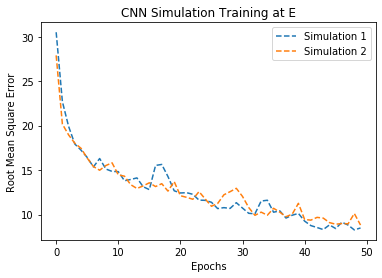

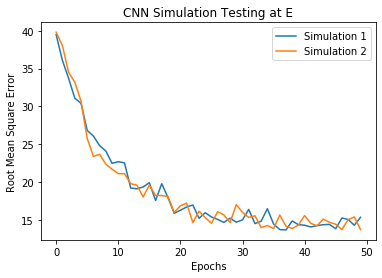

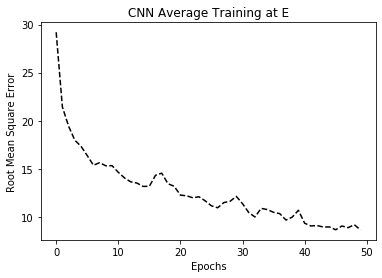

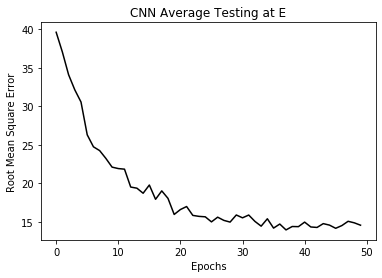

In [9]:
X_E = image_train[location == 5]
y_E = labels_train[location == 5]

k = 5
n_simulations = 5
epochs = 200
batchsize = 64
sim_train_E = np.zeros((n_simulations, epochs))
sim_test_E = np.zeros((n_simulations, epochs))
simulation_list_E = []

for sim in range(n_simulations):
    model_sim_best, Ltrain, Ltest, lowest_val = CNN(X_E, y_E, epochs, k, batchsize, sim)
    
    # Testing model
    data = image_test[location_test == 5]
    data_labels = labels_test[location_test == 5]
    m_label = np.mean(data)
    s_label = np.std(data)
    X_model = norm(data, m_label, s_label)
    R = model_sim_best.evaluate(X_model, data_labels, verbose = 0)
    simulation_list_E.append(R[0])
    
    if sim == 0:
        model_E_best = model_sim_best
        val_marker = lowest_val
    else:
        if lowest_val < val_marker:
            model_E_best = model_sim_best
            val_marker = lowest_val
    
    sim_train_E[sim] = np.mean(Ltrain, axis = 0)
    sim_test_E[sim] = np.mean(Ltest, axis = 0)
    
    plt.figure(1)
    plt.plot(range(epochs), sim_train_E[sim], '--', label = 'Simulation {}'.format(sim+1))
    plt.figure(2)
    plt.plot(range(epochs), sim_test_E[sim], label = 'Simulation {}'.format(sim+1))

plt.figure(3)    
plt.plot(range(epochs), np.mean(sim_train_E, axis = 0), 'k--')
plt.figure(4)    
plt.plot(range(epochs), np.mean(sim_test_E, axis = 0), 'k')

clear_output()

titles = ['CNN Simulation Training at E', 'CNN Simulation Testing at E','CNN Average Training at E', 'CNN Average Testing at E']
for i in range(4):
    plt.figure(i+1)
    plt.title(titles[i])
    plt.xlabel('Epochs')
    plt.ylabel('Root Mean Square Error')
    if i == 0 or i == 1:     
        plt.legend()   
        
overfit = np.sqrt(simulation_list_E) - np.min(sim_train_E, axis = 1)
train_min_mean = np.mean(np.min(sim_train_E, axis = 1))
train_min_std = np.std(np.min(sim_train_E, axis = 1))
test_min_mean = np.mean(np.min(sim_test_E, axis = 1))
test_min_std = np.std(np.min(sim_test_E, axis = 1))
print('Final Training Mean RMSE:',train_min_mean)
print('Final Training STD RMSE:',train_min_std)
print('Final Validation Mean RMSE:',test_min_mean)
print('Final Validation STD RMSE:',test_min_std)
print('The Final Mean RMSE', np.mean(np.sqrt(simulation_list_E)))
print('The Final STD RMSE', np.std(np.sqrt(simulation_list_E)))
print('Overfit Mean', np.mean(overfit))
print('Overfit STD', np.std(overfit))
#-----------------Saving model------------------
# serialize model to JSON
model_json = model_E_best.to_json()
with open("model_E_best.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model_E_best.save_weights("model_E_best.h5")
print("Saved model to disk")

# Plotting all training on one axis

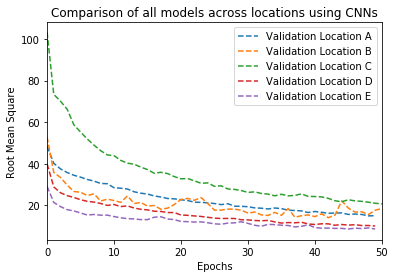

In [13]:
plt.title('Comparison of all models across locations using CNNs')
plt.plot(range(50), np.mean(sim_train_A, axis = 0), '--', label = 'Validation Location A')
plt.plot(range(150), np.mean(sim_train_B, axis = 0), '--', label = 'Validation Location B')
plt.plot(range(400), np.mean(sim_train_C, axis = 0), '--',label = 'Validation Location C')
plt.plot(range(50), np.mean(sim_train_D, axis = 0),'--', label = 'Validation Location D')
plt.plot(range(50), np.mean(sim_train_E, axis = 0),'--', label = 'Validation Location E')
plt.xlabel('Epochs')
plt.ylabel('Root Mean Square')
plt.legend()
plt.xlim(0,50)
plt.savefig('m_CNN_validation.jpg')

# Testing Loading in Model

In [ ]:
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
score = loaded_model.evaluate(X, Y, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

In [ ]:
def prune(model):
    epochs_prune = 1
    batch = 1000
    end_step = np.ceil(1.0 * len(image_train)/batch).astype(np.int32) * epochs_prune
    new_pruning_params = {'pruning_schedule': sparsity.PolynomialDecay(initial_sparsity = 0.25,
                                                       final_sparsity = 0.25,
                                                       begin_step = 0,
                                                       end_step = end_step,
                                                       frequency = 100)}

    new_pruned_model = sparsity.prune_low_magnitude(model, **new_pruning_params)
    new_pruned_model.compile(loss = tf.keras.losses.mean_squared_error, optimizer = 'adam', metrics=['mse'])
    callbacks = [sparsity.UpdatePruningStep()]
    new_pruned_model.fit(image_train, labels_train,
              batch_size = batch,
              epochs = epochs_prune,
              verbose = 1,
              callbacks = callbacks)
    #           validation_data = (x_val, y_val))

    clear_output()
    final_model = sparsity.strip_pruning(new_pruned_model)
    score = new_pruned_model.evaluate(image_test, labels_test, verbose = 0)
    print('initial test RMSE = {:.2f}'.format(np.mean(np.sqrt(simulation_list_E))))
    print('The final test RMSE on the model is {:.2f}'.format(np.sqrt(score[0])))
    
    return new_pruned_model

prune(model_E_best)